# Proyek Analisis Sentimen: Aplikasi Play Store Bumble

## 1. Import Library

In [19]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

## 2. Load Dataset

In [2]:
df = pd.read_csv(r"C:\Users\didan\DBS Coding Camp 2025\Belajar Pengembangan Machine Learning\submission\bumble_reviews.csv")
df.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
29995,8757b390-18ee-4ef0-94a5-ac25d5d8ebf0,Devin Jonathan,https://play-lh.googleusercontent.com/a-/ALV-U...,"Hai pihak bumble, ini aplikasi sangat bagus te...",5,21,5.235.0,2021-09-09 14:36:12,"Halo, kami akan dengan senang hati membantu me...",2021-09-09 22:01:19,5.235.0
29996,66f564e6-4f82-4377-92a1-bf9c7eb0f4cf,Zaenab Fikron Nisa,https://play-lh.googleusercontent.com/a-/ALV-U...,"Tiba tiba ke logout, pas mau masuk lagi masak ...",5,9,5.251.2,2022-01-10 17:58:19,"Halo, kami akan dengan senang hati membantu me...",2022-01-10 21:22:26,5.251.2
29997,66e15dde-eaa9-4964-b578-088a7c47cbbd,Yaa Aya,https://play-lh.googleusercontent.com/a/ACg8oc...,Kok bisa bayar sendiri?padahal ga mau transaks...,1,1,NaN,2024-12-25 13:14:42,NaN,NaN,NaN
29998,aa34c2b4-28e7-462b-be98-fc404a7cb4ea,RexXome,https://play-lh.googleusercontent.com/a-/ALV-U...,"gabisa login, coba fitur call gaada yg masuk, ...",1,0,NaN,2024-10-28 16:26:40,NaN,NaN,NaN
29999,36556e89-d552-4e87-8a12-5595d8e077d9,lingga al kautsar,https://play-lh.googleusercontent.com/a/ACg8oc...,"aplikasi sampah, limit buat gratisan gak otak ...",1,27,5.389.0,2024-10-20 13:54:12,NaN,NaN,5.389.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  23700 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          15900 non-null  object
 9   repliedAt             15900 non-null  object
 10  appVersion            23700 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [4]:
# Membuat df baru (cleaned_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN)
cleaned_df = df.dropna()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 33 to 29996
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               12000 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  12000 non-null  object
 7   at                    12000 non-null  object
 8   replyContent          12000 non-null  object
 9   repliedAt             12000 non-null  object
 10  appVersion            12000 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


## 3.Preprocessing Data
- Normalisasi Teks
- Tokenisasi
- Stopword Removal
- Stemming 
- Handling Emoticons dan Ekspresi Khusus
- Penanganan Slang dan Bahasa Gaul

In [5]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\didan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Kamus emotikon ke teks
emoticon_dict = {
    ":)": "senang", ":-)": "senang", "😊": "senang", "😁": "senang",
    ":(": "sedih", ":-(": "sedih", "😢": "sedih", "😭": "sedih",
    "😡": "marah", "😠": "marah", "😒": "kesal", "😞": "kecewa",
    "😂": "lucu", "🤣": "lucu", "❤️": "cinta", "💔": "patah hati",
    "😍": "suka", "😘": "cium", "😎": "keren", "😱": "kaget"
}

# Kamus slang dan bahasa gaul
slang_dict = {
    # Umum
    "gk": "tidak", "ga": "tidak", "nggak": "tidak", "ngga": "tidak", "tdk": "tidak",
    "bgt": "banget", "bngt": "banget", "amat": "banget",
    "btw": "omongomong", "lol": "lucu", "wkwk": "lucu", "wk": "lucu", "wkwkwk": "lucu",
    "jg": "juga", "aja": "saja", "aj": "saja", "sm": "sama", "sy": "saya",
    "tp": "tapi", "krn": "karena", "karna": "karena", "krna": "karena",
    "cm": "cuma", "cuma2": "cuma", "cuman": "cuma",
    "dr": "dari", "drpd": "daripada", "pd": "pada",
    "udh": "sudah", "sdh": "sudah", "dah": "sudah", "d": "sudah",
    "blm": "belum", "td": "tadi", "trs": "terus", "trus": "terus", "teruss": "terus",
    "lg": "lagi", "dlu": "dulu", "duluan": "dulu", "ajaib": "aneh",
    "emg": "memang", "bgitu": "begitu", "gitu": "begitu", "gtu": "begitu",
    "yaudah": "baiklah", "ywdh": "baiklah",

    # Ekspresi
    "sumpah": "sungguh", "parah": "buruk", "kocak": "lucu", "gaje": "tidak jelas", 
    "lebay": "berlebihan", "bosen": "bosan", "gabut": "tidak ada kegiatan",
    "nyebelin": "menyebalkan", "kesel": "kesal", "cape": "capai", "capek": "capai",
    "pusing": "bingung", "nangis": "menangis", "seneng": "senang",

    # Sosial / aplikasi
    "app": "aplikasi", "fitur": "fitur", "match": "cocok", "unmatch": "tidak cocok",
    "ngobrol": "berbincang", "chat": "pesan", "ngechat": "mengirim pesan",
    "ngehubungin": "menghubungi", "respon": "tanggapan", "fastrespon": "tanggapan cepat",
    "ghosting": "menghilang", "ignored": "diabaikan", "left": "meninggalkan",
    "cocokan": "pasangan", "ketemu": "bertemu", "swipe": "geser",
    "nge-like": "menyukai", "like": "suka", "superlike": "sangat suka",
    "ngeblock": "memblokir", "block": "blokir", "profile": "profil", "bio": "deskripsi",

    # Orang / hubungan
    "cwe": "cewek", "cwek": "cewek", "cewe": "cewek", "cewek2": "cewek",
    "cwk": "cowok", "cwo": "cowok", "cowok2": "cowok",
    "gebetan": "seseorang disukai", "mantan": "bekas pacar", "pdkt": "pendekatan",
    "seringchat": "sering mengobrol", "modus": "berpura-pura baik",

    # Waktu dan lainnya
    "skrg": "sekarang", "besok": "nanti", "tdk": "tidak",
    "bisa2": "bisa", "gimana": "bagaimana", "gmn": "bagaimana",
    "kenapa": "mengapa", "knp": "mengapa", "ngapa": "mengapa",
    "km": "kamu", "mu": "kamu", "lu": "kamu", "loe": "kamu",
    "gua": "saya", "gw": "saya", "gue": "saya", "aq": "aku", "q": "aku"
}

In [7]:
# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def replace_emoticons(text):
    for emot, meaning in emoticon_dict.items():
        text = text.replace(emot, f" {meaning} ")
    return text

def replace_slang(text):
    tokens = text.split()
    return " ".join([slang_dict.get(word, word) for word in tokens])

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase
    text = text.lower()
    # 2. Replace emoticon
    text = replace_emoticons(text)
    # 3. Hapus URL dan mention
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    # 4. Ganti slang
    text = replace_slang(text)
    # 5. Hapus angka dan tanda baca (hanya huruf dan spasi)
    text = re.sub(r'[^a-z\s]', '', text)
    # 6. Tokenisasi
    tokens = text.split()
    # 7. Hapus stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # 8. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)

# Terapkan preprocessing pada kolom 'content' dan simpan ke kolom 'clean_text'
cleaned_df['clean_text'] = cleaned_df['content'].apply(preprocess_text)

C:\Users\didan\AppData\Local\Temp\ipykernel_22560\1249476697.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['clean_text'] = cleaned_df['content'].apply(preprocess_text)


In [8]:
cleaned_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,clean_text
33,375f5d51-33ed-4f91-9b22-f5273e11773d,Wonka Wonka,https://play-lh.googleusercontent.com/a-/ALV-U...,Nilai plus : lembar data informasi pengguna cu...,3,116,5.292.0,2022-10-29 05:48:05,Terima kasih sudah menjadi bagian berharga dar...,2022-10-31 10:52:54,5.292.0,nilai plus lembar data informasi guna lengkap ...
36,04ef3906-1b17-4ab3-b91c-94d0d944d184,Bang Rosad,https://play-lh.googleusercontent.com/a/ACg8oc...,Tolonglah kalo beri feedback seenggaknya bisa ...,1,99,5.280.0,2022-08-07 14:20:27,"Halo, kami akan dengan senang hati membantu me...",2022-08-07 22:40:53,5.280.0,tolong kalo feedback enggak close ngefreeze mu...
38,6b1c5ae4-3b88-4724-97dd-8b7917eea978,Alfian,https://play-lh.googleusercontent.com/a-/ALV-U...,"JANGAN BELI apapun di bumble guys, baik yg pre...",1,136,5.303.0,2023-01-21 08:15:44,"Halo, kami akan dengan senang hati membantu me...",2023-01-21 18:21:18,5.303.0,beli apa bumble guys yg premium beli yg kacau ...
40,e73dee45-2a1e-4021-8367-e4604feb7ead,Lisdha Lascha,https://play-lh.googleusercontent.com/a-/ALV-U...,Kayak buka kamus bergambar 😭 enggres semua. Ta...,4,93,5.242.1,2021-10-27 00:08:53,Terima kasih sudah menyukai kami! Kami senang ...,2021-10-27 13:51:50,5.242.1,kayak buka kamus gambar sedih enggres oke sih ...
53,6b8ad4be-b28e-4fad-b4f9-357c5f006e0a,Resti Sri juliantih,https://play-lh.googleusercontent.com/a-/ALV-U...,"Tiba-tiba akun gabisa dibuka, padahal nomor se...",2,27,5.396.0,2024-11-29 10:26:51,Thanks for letting us know we’re on the right ...,2023-01-15 02:31:03,5.396.0,tibatiba akun gabisa buka nomor sesuai pas daf...


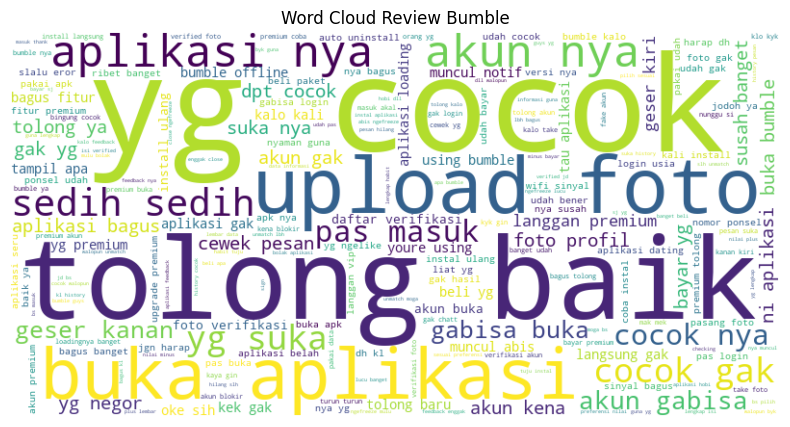

C:\Users\didan\AppData\Local\Temp\ipykernel_22560\2417882961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['word_count'] = cleaned_df['clean_text'].apply(lambda x: len(x.split()))


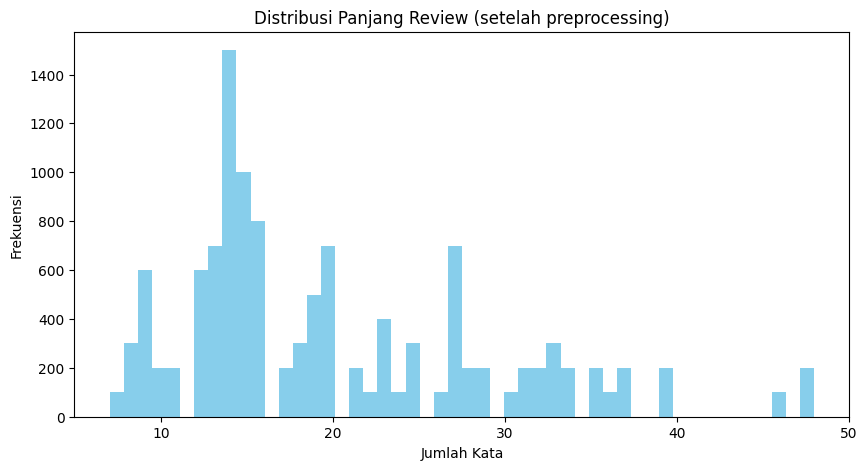

In [9]:
# Visualisasi Word Cloud
all_words = " ".join(cleaned_df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Review Bumble")
plt.show()

# Visualisasi Distribusi Panjang Teks
cleaned_df['word_count'] = cleaned_df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
plt.hist(cleaned_df['word_count'], bins=50, color='skyblue')
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.title("Distribusi Panjang Review (setelah preprocessing)")
plt.show()

## 4. Data Labelling

In [10]:
# URL kamus
url_positif = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
url_negatif = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Baca CSV langsung dari URL
kamus_positif_df = pd.read_csv(url_positif, header=None)
kamus_negatif_df = pd.read_csv(url_negatif, header=None)

# Ubah ke set agar pencarian lebih cepat & pastikan lowercase
kamus_positif = set(kamus_positif_df[0].str.strip().str.lower())
kamus_negatif = set(kamus_negatif_df[0].str.strip().str.lower())

print("Jumlah kata positif:", len(kamus_positif))
print("Jumlah kata negatif:", len(kamus_negatif))

Jumlah kata positif: 3607
Jumlah kata negatif: 6606


In [11]:
# Fungsi pelabelan dengan kamus lexicon
def lexicon_labeling(review):
    tokens = preprocess_text(review).split()
    pos_count = sum(1 for word in tokens if word in kamus_positif)
    neg_count = sum(1 for word in tokens if word in kamus_negatif)
    
    if pos_count > neg_count:
        return 'positif'
    elif neg_count > pos_count:
        return 'negatif'
    else:
        return 'netral'

# Terapkan fungsi pelabelan berbasis lexicon
cleaned_df['sentiment'] = cleaned_df['content'].apply(lambda x: lexicon_labeling(x) if isinstance(x, str) else 'netral')

C:\Users\didan\AppData\Local\Temp\ipykernel_22560\1622509465.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['sentiment'] = cleaned_df['content'].apply(lambda x: lexicon_labeling(x) if isinstance(x, str) else 'netral')


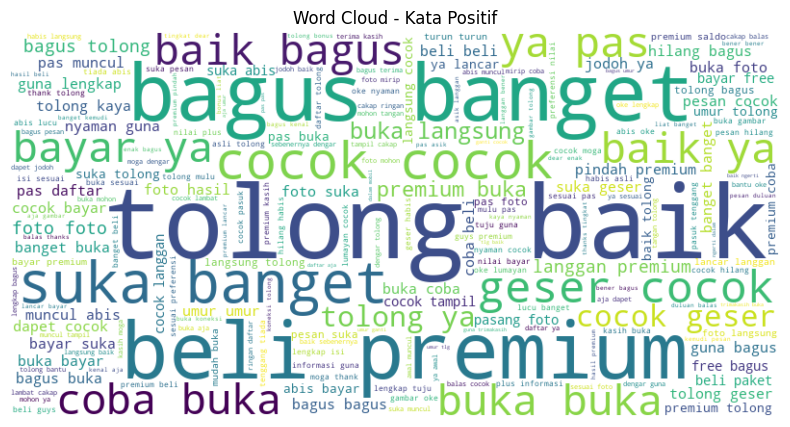

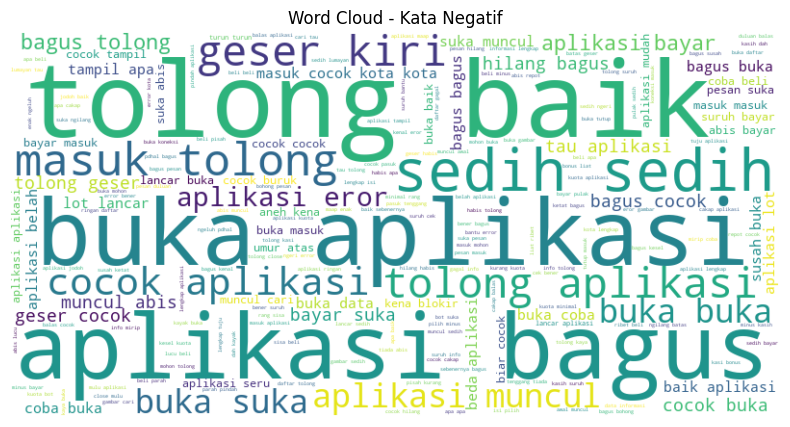

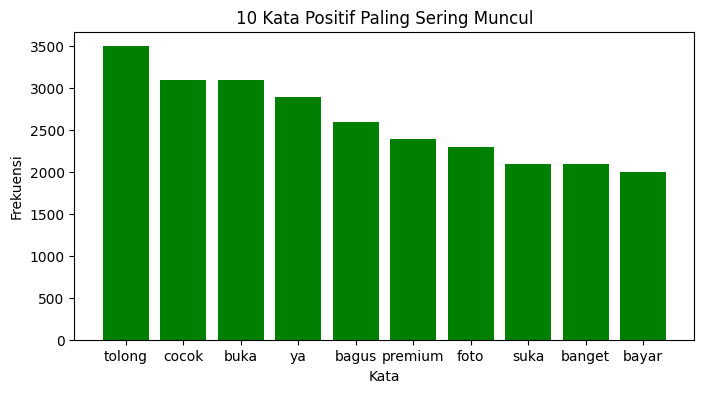

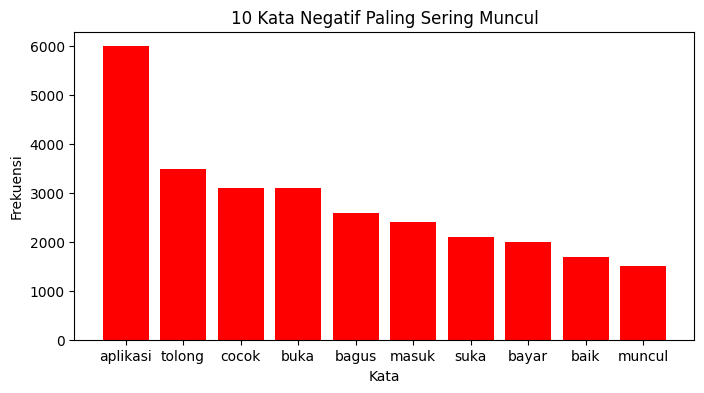

In [12]:
# Gabungkan semua teks dari review yang sudah dipreproses
all_words = " ".join(cleaned_df['clean_text'])

# Tokenisasi 
tokens = all_words.split()

# Pisahkan kata-kata berdasarkan kategori kamus
tokens_positif = [word for word in tokens if word in kamus_positif]
tokens_negatif = [word for word in tokens if word in kamus_negatif]

# word cloud untuk kata positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(" ".join(tokens_positif))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Word Cloud - Kata Positif")
plt.axis('off')
plt.show()

#  word cloud untuk kata negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(" ".join(tokens_negatif))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Word Cloud - Kata Negatif")
plt.axis('off')
plt.show()

# Visualisasi distribusi frekuensi kata positif dan negatif (histogram kata)
counter_pos = Counter(tokens_positif)
counter_neg = Counter(tokens_negatif)

# Ambil 10 kata teratas dari masing-masing
most_common_pos = counter_pos.most_common(10)
most_common_neg = counter_neg.most_common(10)

# Plot untuk positif
words_pos, counts_pos = zip(*most_common_pos)
plt.figure(figsize=(8,4))
plt.bar(words_pos, counts_pos, color='green')
plt.title("10 Kata Positif Paling Sering Muncul")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.show()

# Plot untuk negatif
words_neg, counts_neg = zip(*most_common_neg)
plt.figure(figsize=(8,4))
plt.bar(words_neg, counts_neg, color='red')
plt.title("10 Kata Negatif Paling Sering Muncul")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.show()

In [13]:
cleaned_df[cleaned_df['sentiment'] == 'netral']

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,clean_text,word_count,sentiment
72,64badf8e-7309-4143-af76-88e11c613436,Anika Dwi,https://play-lh.googleusercontent.com/a-/ALV-U...,Tolong diperbaiki dong waktu buka aplikasi sel...,2,61,5.224.0,2021-06-13 17:41:58,"Halo, kami akan dengan senang hati membantu me...",2021-06-14 22:26:30,5.224.0,tolong baik buka aplikasi youre using bumble o...,18,netral
90,0ec40fb3-f697-4ed0-8119-9a9c6839dae8,Zachry Kelent Alfraer,https://play-lh.googleusercontent.com/a-/ALV-U...,Saya sudah pakai apk ini selama beberapa bulan...,2,67,5.252.0,2022-01-19 09:31:52,"Halo, kami akan dengan senang hati membantu me...",2022-01-19 20:25:37,5.252.0,pakai apk aman apk nya buka stag coba instal u...,12,netral
104,2963c7d8-3a2f-43c6-9a22-0b552744e1bd,Neo Bintang liferansa,https://play-lh.googleusercontent.com/a/ACg8oc...,Tiba tiba gabisa login lagi karena masalah usi...,1,11,5.281.0,2022-08-17 11:34:25,"Halo, kami akan dengan senang hati membantu me...",2022-08-18 00:37:41,5.281.0,gabisa login usia loginnya kemarin facebook ba...,15,netral
105,df96656e-6f74-4e38-9bda-ac4f4e371665,Calvin Yosafat,https://play-lh.googleusercontent.com/a-/ALV-U...,heran banget limit buat like nya sedikit bange...,1,177,5.270.1,2022-05-23 00:01:29,"Halo, kami akan dengan senang hati membantu me...",2022-05-23 19:01:14,5.270.1,heran banget limit suka nya banget aplikasi ny...,14,netral
112,fe0930b3-6933-4110-8a7b-abec52bd30ce,Cho Official,https://play-lh.googleusercontent.com/a-/ALV-U...,"Dear bumble,Awalnya ini seru.sya udh chat deng...",2,26,5.228.1,2021-07-22 12:09:33,"Halo, kami akan dengan senang hati membantu me...",2021-07-23 21:17:29,5.228.1,dear bumbleawalnya serusya pesan temen matchin...,27,netral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29981,f298e965-f8ea-4856-8a2e-3d1317f7b8cb,Nay Caballero,https://play-lh.googleusercontent.com/a/ACg8oc...,sekarang kalau buka bumble loading terus ga bi...,2,5,5.330.0,2023-08-06 07:32:12,"Halo, kami akan dengan senang hati membantu me...",2023-08-07 08:48:00,5.330.0,buka bumble loading buka jarak suka ngaco filter,8,netral
29982,15cf3ea3-1fbb-438d-8867-5811716fc18a,Grafika Putri,https://play-lh.googleusercontent.com/a/ACg8oc...,akun tiba2 ke log out sendiri dann mau login g...,1,63,5.192.0,2020-10-12 11:23:53,"Halo, kami akan dengan senang hati membantu me...",2020-10-12 21:18:34,5.192.0,akun log out dann login gabisa tulis over in r...,31,netral
29984,0017f104-8060-4833-affc-b30b1458a9f3,Nadira Debora,https://play-lh.googleusercontent.com/a/ACg8oc...,Aplikasi apa ini saya harus enter code tapi co...,1,3,5.330.0,2023-08-06 05:07:30,"Halo, kami akan dengan senang hati membantu me...",2023-08-07 08:45:33,5.330.0,aplikasi enter code codenya muncul muncul mara...,9,netral
29992,2e4ce647-32a5-409a-b9b5-6afcb40975b4,I'M Loly,https://play-lh.googleusercontent.com/a-/ALV-U...,Selama ini berjalan cukup baik cuma saran kala...,5,2,5.229.0,2021-07-24 03:15:48,Terima kasih sudah menyukai kami! Kami senang ...,2021-08-13 17:40:26,5.229.0,jalan saran balas pesan suka thankyou bumble,7,netral


## 5. Data Split

In [14]:
X = cleaned_df['clean_text']
y = cleaned_df['sentiment']

In [15]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [16]:
# Konversi hasil ekstraksi fitur menjadi df
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,abis,ad,aja,akun,aneh,apa,apk,apknya,aplikasi,atas,...,via,vip,walopun,wifi,woi,ya,yaa,yg,your,youre
0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.078990,0.000000,...,0.000000,0.0,0.455654,0.0,0.0,0.000000,0.0,0.183088,0.0,0.0
1,0.250407,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.270635,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.132787,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.210241,0.0,0.0
3,0.174409,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.094248,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.471665,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.000000,0.0,0.0,0.146623,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
11996,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
11997,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.505402,0.0,0.000000,0.0,0.0,0.000000,0.0,0.230537,0.0,0.0
11998,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.187532,0.411807,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [17]:
# split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

## 6. Skema Pelatihan Model

#### Skema 1 SVM, TFIDF, 70:30


In [20]:
# Membuat objek model SVM (linear kernel)
svm_model = LinearSVC()

# Melatih model
svm_model.fit(X_train, y_train)

# Prediksi
y_pred_train_svm = svm_model.predict(X_train)
y_pred_test_svm = svm_model.predict(X_test)

# Evaluasi akurasi
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)


SVM - accuracy_train: 1.0
SVM - accuracy_test: 1.0


#### Skema 2 Random Forest, TFIDF, 70:30


In [21]:
# Membuat objek model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model
rf_model.fit(X_train, y_train)

# Prediksi
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluasi akurasi
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 1.0
Random Forest - accuracy_test: 1.0


#### Skema 3 DecisionTree, TFIDF, 80:20

In [32]:
# split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2
                                                    , random_state=42)

In [33]:
# Membuat objek model Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)

# Melatih model
tree_model.fit(X_train, y_train)

# Prediksi
y_pred_train_tree = tree_model.predict(X_train)
y_pred_test_tree = tree_model.predict(X_test)

# Evaluasi akurasi
accuracy_train_tree = accuracy_score(y_train, y_pred_train_tree)
accuracy_test_tree = accuracy_score(y_test, y_pred_test_tree)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_tree)
print('Decision Tree - accuracy_test:', accuracy_test_tree)


Decision Tree - accuracy_train: 1.0
Decision Tree - accuracy_test: 1.0


#### Skema 4 Naive Baiyes, TFIDF, 70:30

In [23]:
# Membuat objek model (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()

# Melatih model pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)

Naive Bayes - accuracy_train: 0.9392857142857143
Naive Bayes - accuracy_test: 0.9472222222222222


In [24]:
# Simpan model ke file .pkl
joblib.dump(naive_bayes, 'naive_bayes_model.pkl')
print("Model berhasil disimpan.")

Model berhasil disimpan.


In [26]:
# Simpan TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

#### Insight
- SVM, RF, DecisionTree, menunjukkan akurasi yang sempurna pada training set dan testing set, yang kemungkinan overfitting
- NaiveBayes dengan TFID 70:30 mendapat akurasi train dan test yang optimal dengan 94% rata-rata